<a href="https://colab.research.google.com/github/Rucamont/Yolo--HeatMap-Track/blob/main/Yoloy_HeatMap%26Track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output

! pip install ultralytics  -qq
! pip install supervision==0.24.0 -qq
! pip install imagehash -qq
clear_output()

In [12]:
import os
import torch
import warnings
import pandas as pd
import supervision as sv
import subprocess
import base64
import hashlib
import imagehash
import cv2
import time
from PIL import Image
from ultralytics import YOLO
from IPython.display import Video
from google.colab.patches import cv2_imshow

# print(cv2.__version__)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
warnings.filterwarnings('ignore')




# Forzar el uso de la CPU
device = torch.device("cpu")

In [18]:
def get_video_properties(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        raise ValueError("Could not open video file")

    # Get video properties
    properties = {
        "fps": int(cap.get(cv2.CAP_PROP_FPS)),
        "frame_count": int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        "duration_seconds": int( cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS) ),
        "width": int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        "height": int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        "codec": int(cap.get(cv2.CAP_PROP_FOURCC)),
    }

    # Release the video capture object
    cap.release()

    return properties

In [6]:
video_properties = get_video_properties('camara_retail.mp4')
video_properties

{'fps': 13,
 'frame_count': 1283,
 'duration_seconds': 97,
 'width': 634,
 'height': 360,
 'codec': 875967080}

In [3]:
def download_video() -> str:
    download_assets(VideoAssets.PEOPLE_WALKING)
    return VideoAssets.PEOPLE_WALKING.value
def generate_image_hash(image_base64):
    # Decodificar la imagen de base64 y generar un hash
    image_bytes = base64.b64decode(image_base64)
    return hashlib.sha256(image_bytes).hexdigest()  # Usamos SHA-256 para obtener el hash

def generate_perceptual_hash(cropped_image):
    # Generar un hash perceptual (pHash) de la imagen

    return imagehash.phash(Image.fromarray(cropped_image),hash_size=5)


In [18]:
def heatmap_and_track(
    source_weights_path: str,
    source_video_path: str,
    target_video_path: str,
    confidence_threshold: float = 0.35,
    iou_threshold: float = 0.5,
    heatmap_alpha: float = 0.5,
    radius: int = 25,
    track_activation_threshold: float = 0.35,
    track_seconds: int = 5,
    minimum_matching_threshold: float = 0.99,
) -> None:
    ### instantiate model
    model = YOLO(source_weights_path)

    # Folder to save detected object images
    output_folder = "detections"
    os.makedirs(output_folder, exist_ok=True)
    object_counter = 0  # To keep track of saved images

    ### heatmap config
    heat_map_annotator = sv.HeatMapAnnotator(
        position=sv.Position.BOTTOM_CENTER,
        opacity=heatmap_alpha,
        radius=radius,
        kernel_size=25,
        top_hue=0,
        low_hue=125,
    )

    ### annotation config
    label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)

    ### get the video fps
    cap = cv2.VideoCapture(source_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    cap.release()

    ### tracker config
    byte_tracker = sv.ByteTrack(
        track_activation_threshold=track_activation_threshold,
        lost_track_buffer=track_seconds * fps,
        minimum_matching_threshold=minimum_matching_threshold,
        frame_rate=fps,
    )

    ### video config
    video_info = sv.VideoInfo.from_video_path(video_path=source_video_path)
    frames_generator = sv.get_video_frames_generator(
        source_path=source_video_path, stride=1
    )

    ### Detect, track, annotate, save
    with sv.VideoSink(target_path=target_video_path, video_info=video_info) as sink:
        for frame in frames_generator:
            result = model(
                source=frame,
                conf=confidence_threshold,
                iou=iou_threshold,
                device=None,
            )[0]
            class_names = model.names

            for detection in result.boxes:
                box = detection.xyxy[0]
                x1, y1, x2, y2 = map(int, box[:4])
                class_id = int(detection.cls[0])
                confidence = detection.conf[0]

                class_name = class_names.get(class_id, "Unknown")
                print(f"Detected class: {class_name} (ID: {class_id}, Confidence: {confidence:.2f})")

                # Recortar la imagen
                cropped_image = frame[y1:y2, x1:x2]

                # Convertir imagen recortada a base64
                _, buffer = cv2.imencode('.jpg', cropped_image)
                b64_string = base64.b64encode(buffer).decode('utf-8')
                perceptual_hash = generate_perceptual_hash(cropped_image)

                """ Lineas del código para guradar las imagenes en una base de """
                # try:
                #     img = ImageDB(classname=class_name, _base64=b64_string, _image_hash=str(perceptual_hash))
                #     img.save()
                #     print("Imagen guardada correctamente.")
                # except Exception as e:
                #     print(f"Error al guardar la imagen: {e}")



            detections = sv.Detections.from_ultralytics(result)  # get detections

            detections = byte_tracker.update_with_detections(
                detections
            )  # update tracker

            ### draw heatmap
            annotated_frame = heat_map_annotator.annotate(
                scene=frame.copy(), detections=detections
            )

            ### draw other attributes from `detections` object
            labels = [
                f"#{tracker_id}"
                for class_id, tracker_id in zip(
                    detections.class_id, detections.tracker_id
                )
            ]

            label_annotator.annotate(
                scene=annotated_frame, detections=detections, labels=labels
            )

            # sink.write_frame(frame=annotated_frame)
            # Show the annotated frame in a window
              # Display the annotated frame in the notebook
            clear_output(wait=True)  # Clear the previous output
            cv2_imshow(annotated_frame)  # Show the current annotated frame
            time.sleep(1 / fps)


            # Release resources
        # cv2.destroyAllWindows()


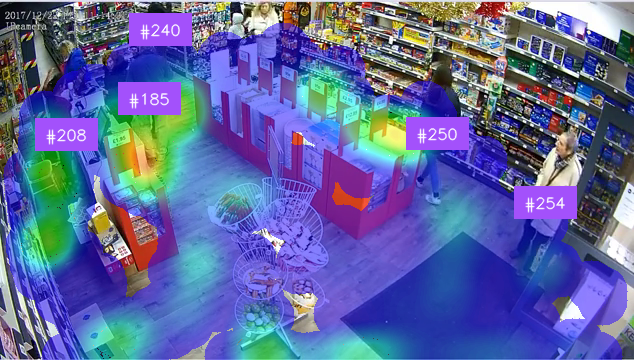

In [19]:
last_saved_time = time.time()
source_weights_path = 'yolov8n.pt'
source_video_path = 'camara_retail.mp4'
confidence_threshold = 0.3
target_video_path = 'output_video.mp4'
iou_threshold = 0.5
heatmap_alpha = 0.5
radius = 25
track_activation_threshold = 0.35
track_seconds = 5
minimum_matching_threshold = 0.99
track_threshold = 0.35
match_threshold = 0.99
heatmap_and_track(
    source_weights_path= source_weights_path,
    source_video_path= source_video_path,
    target_video_path= target_video_path,
    confidence_threshold= confidence_threshold,
    iou_threshold= iou_threshold,
    heatmap_alpha=heatmap_alpha,
    radius=radius,
    track_activation_threshold=track_threshold,
    track_seconds=track_seconds,
    minimum_matching_threshold=match_threshold,
)